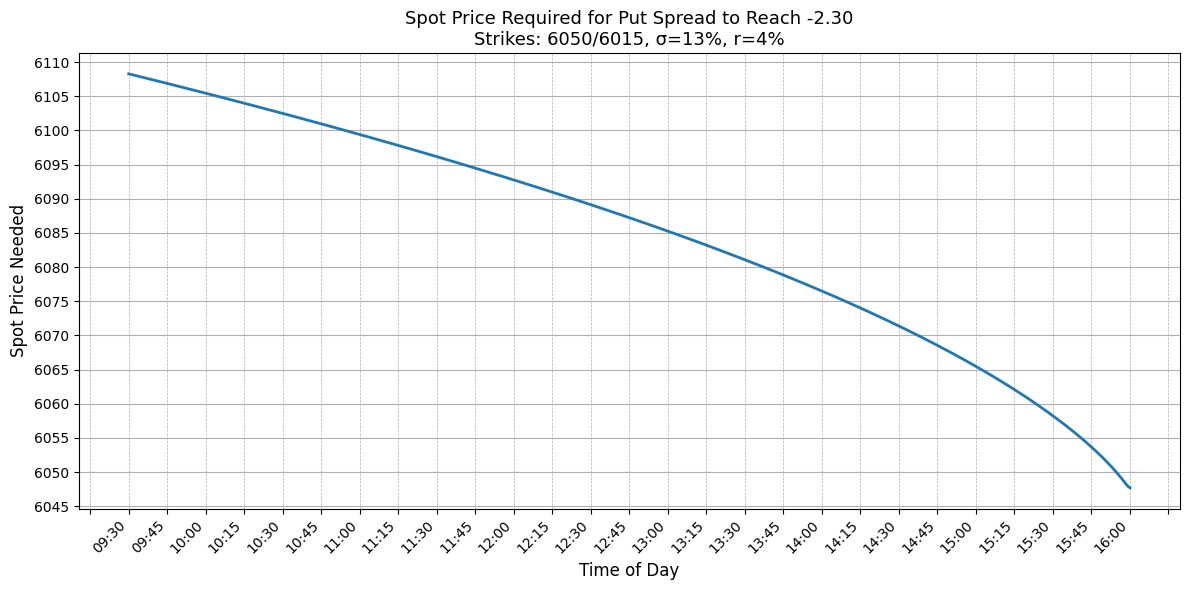

In [39]:
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from datetime import datetime, timedelta

def norm_cdf(x):
    return (1.0 + math.erf(x / math.sqrt(2.0))) / 2.0

def black_scholes_price(S, K, T, r, sigma, option_type):
    if T <= 0:
        if option_type == 'call':
            return max(S - K, 0.0)
        else:
            return max(K - S, 0.0)
    
    if S <= 0 or sigma <= 0 or T <= 0:
        if option_type == 'call':
            return max(S - K, 0.0)
        else:
            return max(K - S, 0.0)
    
    d1 = (math.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)
    
    if option_type == 'call':
        price = S * norm_cdf(d1) - K * math.exp(-r * T) * norm_cdf(d2)
    else:
        price = K * math.exp(-r * T) * norm_cdf(-d2) - S * norm_cdf(-d1)
    
    return max(price, 0.0)

def find_spot_for_spread(target_value, K_short, K_long, T, r, sigma, option_type, tol=1e-8, max_iter=1000):
    if option_type == 'put':
        min_value = K_long - K_short
        max_value = 0.0
        if target_value < min_value or target_value > max_value:
            raise ValueError(f"Target value must be in [{min_value:.4f}, {max_value}] for put spread")
    elif option_type == 'call':
        min_value = K_short - K_long
        max_value = 0.0
        if target_value < min_value or target_value > max_value:
            raise ValueError(f"Target value must be in [{min_value:.4f}, {max_value}] for call spread")
    else:
        raise ValueError("option_type must be 'call' or 'put'")
    
    def F(S):
        if option_type == 'put':
            long_leg = black_scholes_price(S, K_long, T, r, sigma, 'put')
            short_leg = black_scholes_price(S, K_short, T, r, sigma, 'put')
        else:
            long_leg = black_scholes_price(S, K_long, T, r, sigma, 'call')
            short_leg = black_scholes_price(S, K_short, T, r, sigma, 'call')
        return (long_leg - short_leg) - target_value
    
    low = 0.0
    high = 2 * max(K_short, K_long)
    
    f_low = F(low)
    f_high = F(high)
    
    if option_type == 'put':
        while f_high < 0:
            high *= 2
            f_high = F(high)
            if high > 1e12:
                raise RuntimeError("Failed to find upper bound for put spread")
    else:
        while f_low > 0:
            low = max(0, low - 0.5 * (high - low))
            if low < 0:
                low = 0
            f_low = F(low)
    
    for _ in range(max_iter):
        mid = (low + high) / 2
        f_mid = F(mid)
        
        if abs(f_mid) < tol or (high - low) < tol:
            return mid
        
        if f_low * f_mid <= 0:
            high = mid
            f_high = f_mid
        else:
            low = mid
            f_low = f_mid
    
    return (low + high) / 2


def plot_spot_vs_time(target_value, K_short, K_long, r, sigma, option_type):
    # Trading hours (9:30 AM to 4 PM)
    market_open = datetime.strptime("09:30:00", "%H:%M:%S")
    market_close = datetime.strptime("16:00:00", "%H:%M:%S")
    
    # Create time points (every minute)
    time_points = []
    current_time = market_open
    while current_time <= market_close:
        time_points.append(current_time)
        current_time += timedelta(minutes=1)
    
    # Calculate remaining time (in years) for each point
    total_trading_hours = 6.5  # 9:30-4:00 is 6.5 hours
    T_values = []
    spot_prices = []
    
    for i, time in enumerate(time_points):
        minutes_passed = i
        minutes_remaining = len(time_points) - i - 1
        T = (minutes_remaining / (total_trading_hours * 60)) / 252  # Convert to years
        
        try:
            spot = find_spot_for_spread(target_value, K_short, K_long, T, r, sigma, option_type)
            spot_prices.append(spot)
            T_values.append(T * 252 * total_trading_hours * 60)  # Convert back to minutes remaining
        except Exception as e:
            print(f"Error at time {time}: {str(e)}")
            spot_prices.append(np.nan)
            T_values.append(np.nan)
            
    # Plot
    '''
    plt.figure(figsize=(12, 6))
    plt.plot([t.strftime("%H:%M") for t in time_points], spot_prices)
    plt.xlabel("Time of Day")
    plt.ylabel("Spot Price Needed")
    plt.title(f"Spot Price Required for {option_type.capitalize()} Spread to Reach {target_value:.2f}\n"
              f"Strikes: {K_short}/{K_long}, σ={sigma:.0%}, r={r:.0%}")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()'''
    
        # Create plot
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot data
    ax.plot([t.strftime("%H:%M") for t in time_points], spot_prices, linewidth=2)
    
    # Set 15-minute intervals for ticks and grid
    ax.xaxis.set_major_locator(MultipleLocator(15))
    ax.grid(which='major', axis='x', linestyle='--', linewidth=0.5)
    ax.yaxis.set_major_locator(MultipleLocator(5))
    ax.grid(which='major', axis='y')
    # Formatting
    ax.set_xlabel("Time of Day", fontsize=12)
    ax.set_ylabel("Spot Price Needed", fontsize=12)
    ax.set_title(
        f"Spot Price Required for {option_type.capitalize()} Spread to Reach {target_value:.2f}\n"
        f"Strikes: {K_short}/{K_long}, σ={sigma:.0%}, r={r:.0%}",
        fontsize=13
    )
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    
    # Improve layout and show plot
    plt.tight_layout()
    plt.show()

#spot_price = find_spot_for_spread(-2.1, 6050, 6020, 1.0/252, 0.04, 0.13, 'put')
#print(spot_price)
plot_spot_vs_time(
    target_value=-2.30,  # Target credit spread value (negative for credit)
    K_short=6050,       # Short strike
    K_long=6015,        # Long strike
    r=0.04,             # 4% risk-free rate
    sigma=0.13,         # 15% volatility
    option_type='put'    # Put credit spread
)


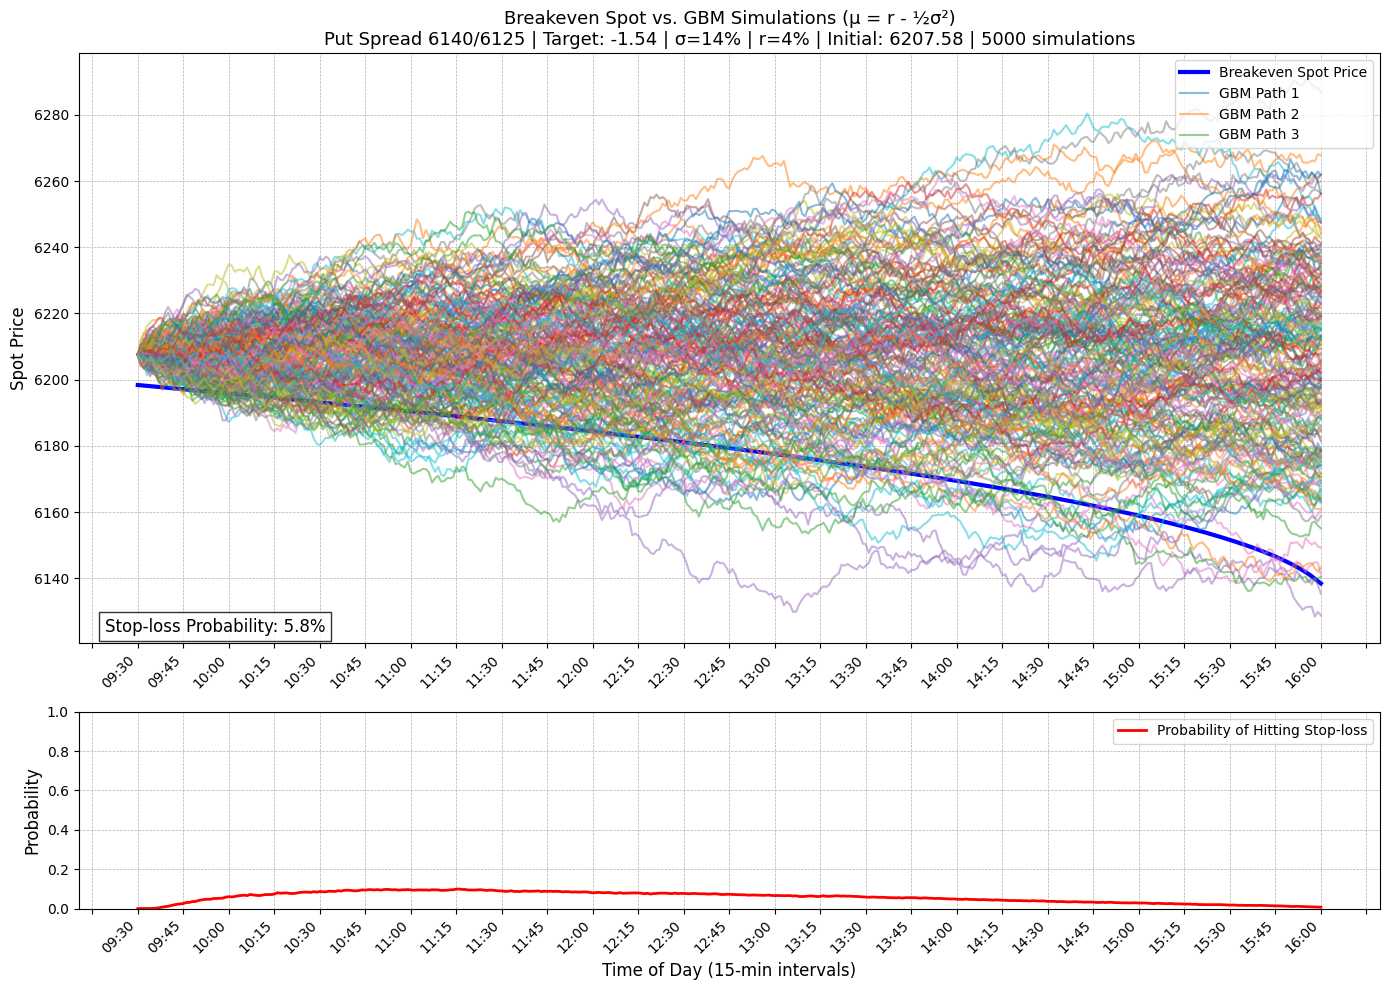

In [42]:
def simulate_gbm(S0, T, r, sigma, n_steps):
    """Simulate Geometric Brownian Motion with proper drift"""
    dt = T / n_steps
    t = np.linspace(0, T, n_steps + 1)
    
    # Brownian increments
    dW = np.random.normal(0, np.sqrt(dt), size=n_steps)
    
    # Proper drift term (r - 0.5*sigma^2)
    drift = (r - 0.5 * sigma ** 2) * dt
    
    # Cumulative returns
    returns = np.cumsum(drift + sigma * dW)
    
    # Price path
    S = S0 * np.exp(np.concatenate(([0], returns)))
    return t, S

def plot_spot_with_gbm(target_value, K_short, K_long, r, sigma, option_type, initial_spot, n_simulations=1000):
    # Trading hours setup
    market_open = datetime.strptime("09:30:00", "%H:%M:%S")
    market_close = datetime.strptime("16:00:00", "%H:%M:%S")
    time_points = [market_open + timedelta(minutes=x) for x in range(0, 391)]  # 6.5 hours
    
    # Calculate theoretical breakeven prices
    breakeven_prices = []
    for i, time in enumerate(time_points):
        minutes_remaining = 390 - i
        T = (minutes_remaining / (6.5 * 60)) / 252
        
        try:
            spot = find_spot_for_spread(target_value, K_short, K_long, T, r, sigma, option_type)
            breakeven_prices.append(spot)
        except:
            breakeven_prices.append(np.nan)
    
    # Setup plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), height_ratios=[3, 1])
    
    # Plot breakeven prices
    ax1.plot([t.strftime("%H:%M") for t in time_points], breakeven_prices, 
            'b-', linewidth=3, label='Breakeven Spot Price')
    
    # Simulate GBM paths and track hits
    total_trading_hours = 6.5
    T = total_trading_hours / (252 * 24)  # Convert trading hours to years
    n_steps = len(time_points) - 1
    
    hit_counts = np.zeros(len(time_points))
    displayed_paths = min(200, n_simulations)  # Number of paths to display
    
    for i in range(n_simulations):
        _, S = simulate_gbm(initial_spot, T, r, sigma, n_steps)
        
        # Track if path hits below breakeven
        hit_below = np.any(S < np.array(breakeven_prices))
        if hit_below:
            hit_counts += (S < np.array(breakeven_prices))
        
        # Display first few paths
        if i < displayed_paths:
            ax1.plot([t.strftime("%H:%M") for t in time_points], S, 
                    alpha=0.5, linewidth=1.5, label=f'GBM Path {i+1}' if i < 3 else "")
    
    # Calculate hit probability
    hit_probability = hit_counts / n_simulations
    ax2.plot([t.strftime("%H:%M") for t in time_points], hit_probability, 
             'r-', linewidth=2, label='Probability of Hitting Stop-loss')
    
    # Formatting
    for ax in [ax1, ax2]:
        ax.xaxis.set_major_locator(MultipleLocator(15))
        ax.grid(which='major', axis='both', linestyle='--', linewidth=0.5)
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    
    ax1.set_ylabel("Spot Price", fontsize=12)
    ax2.set_ylabel("Probability", fontsize=12)
    ax2.set_xlabel("Time of Day (15-min intervals)", fontsize=12)
    ax2.set_ylim(0, 1)
    
    title = (f"Breakeven Spot vs. GBM Simulations (μ = r - ½σ²)\n"
             f"{option_type.capitalize()} Spread {K_short}/{K_long} | "
             f"Target: {target_value:.2f} | σ={sigma:.0%} | r={r:.0%} | "
             f"Initial: {initial_spot} | {n_simulations} simulations")
    ax1.set_title(title, fontsize=13)
    
    # Add probability summary
    final_prob = np.mean(hit_probability)
    ax1.text(0.02, 0.02, f'Stop-loss Probability: {final_prob:.1%}', 
             transform=ax1.transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.8))
    
    # Add legend (show only first 3 paths to avoid clutter)
    handles, labels = ax1.get_legend_handles_labels()
    ax1.legend(handles[:4], labels[:4], loc='upper right')
    ax2.legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    

plot_spot_with_gbm(
    target_value=-1.539,
    K_short=6140,
    K_long=6125,
    r=0.04,
    sigma=0.135,
    option_type='put',
    initial_spot=6207.58,
    n_simulations=5000
)